<a href="https://colab.research.google.com/github/raulbenitez/DEEPCARDIO/blob/master/sportsClassifier/sports_classifier_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Arguments

In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
	help="path to input dataset")
ap.add_argument("-m", "--model", required=True,
	help="path to output serialized model")
ap.add_argument("-l", "--label-bin", required=True,
	help="path to output label binarizer")
ap.add_argument("-e", "--epochs", type=int, default=25,
	help="# of epochs to train our network for")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
args = vars(ap.parse_args())

In [ ]:
args = {"dataset": 'drive/My Drive/tfm/learn/SportsClassifier/Sports-Type-Classifier/data/',
        "model": 'drive/My Drive/tfm/learn/SportsClassifier/model/activity.model',
        "label_bin": 'drive/My Drive/tfm/learn/SportsClassifier/model/lb.pickle',
        "plot": 'drive/My Drive/tfm/learn/SportsClassifier/model/plot',
        "epochs": 25}

In [ ]:
import os
os.listdir('drive/My Drive/tfm/learn/SportsClassifier/')

['Sports-Type-Classifier',
 'model',
 'video',
 'sports_classifier_predict.ipynb',
 'sports_classifier_train.ipynb']

## Labels and load data

In [ ]:
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["weight_lifting", "ice_hockey", "football"])
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue
	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

[INFO] loading images...


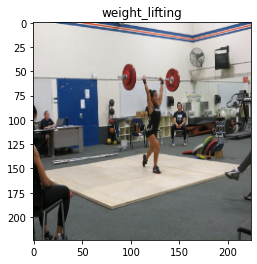

In [ ]:
i = 2000
plt.imshow(data[i])
plt.title(labels[i])
plt.savefig('drive/My Drive/tfm/learn/SportsClassifier/sample_image')

## One-hot encoding labels and split data

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)

## Data augmentation

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

## Load model and replace head

In [ ]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


## Compile and train model

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / args["epochs"])
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=args["epochs"])

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
48/48 [==============================] - 19s 388ms/step - loss: 1.4335 - accuracy: 0.4383 - val_loss: 0.6201 - val_accuracy: 0.7852
Epoch 2/25
48/48 [==============================] - 18s 375ms/step - loss: 0.7723 - accuracy: 0.6766 - val_loss: 0.3818 - val_accuracy: 0.8867
Epoch 3/25
48/48 [==============================] - 18s 375ms/step - loss: 0.5840 - accuracy: 0.7650 - val_loss: 0.3123 - val_accuracy: 0.9023
Epoch 4/25
48/48 [==============================] - 18s 377ms/step - loss: 0.4703 - accuracy: 0.8073 - val_loss: 0.2738 - val_accuracy: 0.9180
Epoch 5/25
48/48 [==============================] - 18s 376ms/step - loss: 0.4126 - accuracy: 0.8495 - val_loss: 0.2536 - val_accuracy: 0.9238
Epoch 6/25
48/48 [==============================] - 18s 378ms/step - loss: 0.3989 - accuracy: 0.8455 - val_loss: 0.2221 - val_accuracy: 0.9297
Epoch 7/25
48/48 [==============================] - 18s 377ms/step - loss: 0.3672 - accuracy

## Evaluation

In [ ]:
args["plot"]

'drive/My Drive/tfm/learn/SportsClassifier/model/plot'

[INFO] evaluating network...
                precision    recall  f1-score   support

      football       0.97      0.94      0.96       196
    ice_hockey       0.96      0.96      0.96       177
weight_lifting       0.93      0.95      0.94       143

      accuracy                           0.95       516
     macro avg       0.95      0.95      0.95       516
  weighted avg       0.95      0.95      0.95       516



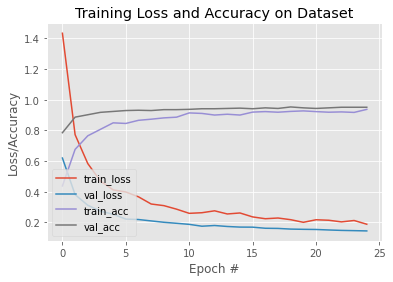

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))
# plot the training loss and accuracy
N = args["epochs"]
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

## Saving model and binarizer

In [ ]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save(args["model"], save_format="h5")
# serialize the label binarizer to disk
f = open(args["label_bin"], "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network...
